# Entropix with Smollm - Scaling a tiny reasoning machine

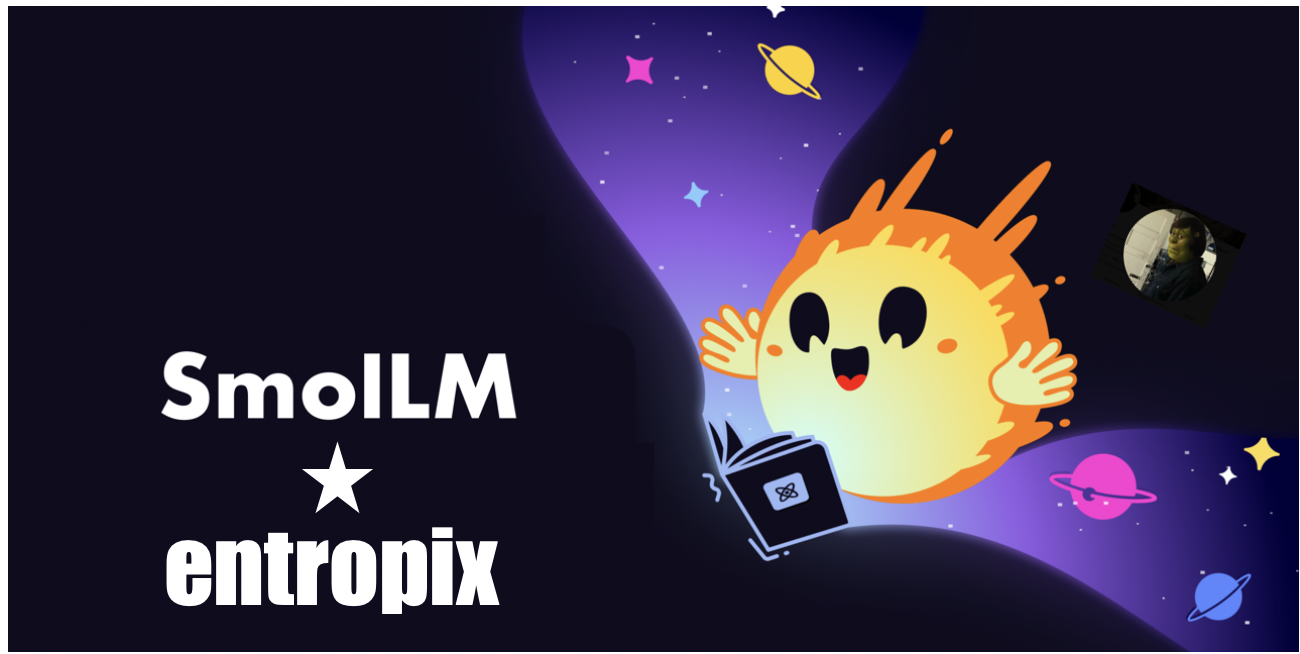

This script is a modified version with updated sampler, metric visualization and tuned entropy, varentropy tresholds of the original notebook from https://x.com/Dorialexander for smolLM and https://x.com/citizenhicks for llama 1B. Model/tokenizer params have been modified to support smollm-330m instead.

<a href="https://colab.research.google.com/github/SinatrasC/entropix-smollm/blob/main/smollm_entropix_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs and initial imports

In [ ]:
!pip install tyro
!pip install tiktoken
!pip install blobfile

In [ ]:
from typing import NamedTuple, Optional, Tuple, List
import torch
import torch.nn.functional as F
import tyro

# Set Model ID and Token

In [ ]:
MODEL_ID = 'HuggingFaceTB/SmolLM-360M-Instruct' #No need for tokens as Smollm is not gated!

# Config

In [ ]:
from typing import NamedTuple
params = {
    "dim": 960,
    "n_layers": 32,
    "n_heads": 15,
    "n_kv_heads": 5,
    "vocab_size": 49152,
    "norm_eps": 1e-05,
    "rope_theta": 10000.0,
    "use_scaled_rope": False,  # Inferred from "rope_scaling": null
    "max_seq_len": 2048,  # Inferred from "max_position_embeddings"
}


class ModelParams(NamedTuple):
  n_layers: int
  n_local_heads: int
  n_local_kv_heads: int
  head_dim: int
  max_seq_len: int
  rope_theta: float
  use_scaled_rope: bool


LLAMA_1B_PARAMS = ModelParams(
  n_layers=params["n_layers"],
  n_local_heads=params["n_heads"],
  n_local_kv_heads=params["n_kv_heads"],
  head_dim=params["dim"] // params["n_heads"],
  max_seq_len=params["max_seq_len"],
  rope_theta=params["rope_theta"],
  use_scaled_rope=params["use_scaled_rope"]
)

# Download Weights

In [ ]:
import os
import torch
import ml_dtypes
import jax.numpy as jnp
import jax
from pathlib import Path

from transformers import AutoModelForCausalLM
from unittest.mock import patch
from transformers.dynamic_module_utils import get_imports

In [ ]:
def translate_key(in_key: str):
    out_key = in_key.replace('.weight', '')
    if out_key.startswith('model.'):
        out_key = out_key.replace('model.', '')
        if out_key.endswith('input_layernorm'):
            out_key = out_key.replace('input_layernorm', 'attention_norm')
        elif out_key.endswith('mlp.down_proj'):
            out_key = out_key.replace('mlp.down_proj', 'feed_forward.w2')
        elif out_key.endswith('mlp.gate_proj'):
            out_key = out_key.replace('mlp.gate_proj', 'feed_forward.w1')
        elif out_key.endswith('mlp.up_proj'):
            out_key = out_key.replace('mlp.up_proj', 'feed_forward.w3')
        elif out_key.endswith('post_attention_layernorm'):
            out_key = out_key.replace('post_attention_layernorm', 'ffn_norm')
        elif out_key.endswith('self_attn.k_proj'):
            out_key = out_key.replace('self_attn.k_proj', 'attention.wk')
        elif out_key.endswith('self_attn.o_proj'):
            out_key = out_key.replace('self_attn.o_proj', 'attention.wo')
        elif out_key.endswith('self_attn.q_proj'):
            out_key = out_key.replace('self_attn.q_proj', 'attention.wq')
        elif out_key.endswith('self_attn.v_proj'):
            out_key = out_key.replace('self_attn.v_proj', 'attention.wv')
        elif out_key.endswith('down_proj'):
            out_key = out_key.replace('down_proj', 'w2')
        elif out_key.endswith('gate_proj'):
            out_key = out_key.replace('gate_proj', 'w1')
        elif out_key.endswith('up_proj'):
            out_key = out_key.replace('up_proj', 'w3')
        elif out_key == 'embed_tokens':
            out_key = 'tok_embeddings'
        elif out_key == 'norm':
            out_key = 'norm'
        else:
            print(f"Don't know how to handle {in_key=}")
    elif out_key == 'lm_head':
        out_key = 'output'
    else:
        print(f"Don't know how to handle {in_key=}")
    return f'{out_key}.weight'

def reverse_permute(tensor: torch.Tensor, n_heads: int = 15, dim1: int = 960, dim2: int = 960) -> torch.Tensor:
    return tensor.view(n_heads, 2, dim1 // n_heads // 2, dim2).transpose(1, 2).reshape(dim1, dim2)

def fixed_get_imports(filename: str | os.PathLike) -> list[str]:
    """Work around for https://huggingface.co/microsoft/phi-1_5/discussions/72."""
    if not str(filename).endswith("/modeling_deepseek.py"):
        return get_imports(filename)
    imports = get_imports(filename)
    imports.remove("flash_attn")
    return imports

def download_weights(model_id: str = MODEL_ID, out_dir: Path = Path('weights/1B-Instruct')):
    device = torch.device("cpu")
    if not out_dir.exists():
        out_dir.mkdir(parents=True, exist_ok=True)

    with patch("transformers.dynamic_module_utils.get_imports", fixed_get_imports):
        hf_model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.bfloat16, offload_folder="/tmp/offload", device_map='cpu')
        with torch.no_grad():
            state_dict = hf_model.state_dict()
            for hf_name, param in state_dict.items():
                print(f' {hf_name}: {param.shape=}')
                name = translate_key(hf_name)
                param = param.cpu()
                if name.endswith('wq.weight'):
                    param = reverse_permute(param, n_heads=15, dim1=960, dim2=960)  # 362M
                elif name.endswith('wk.weight'):
                    param = reverse_permute(param, n_heads=5, dim1=320, dim2=960)  # 362M
                else:
                    pass
                bf16_np_out = param.cpu().view(dtype=torch.uint16).numpy().view(ml_dtypes.bfloat16)
                bf16_out = jnp.asarray(bf16_np_out, dtype=jnp.bfloat16).reshape(*param.shape)
                print(f'Writing {hf_name} as {name} to {out_dir}/{name}.npy')
                jnp.save(f'{out_dir}/{name}.npy', bf16_out)
    del hf_model
    del state_dict

download_weights()
jax.clear_caches()
torch.cuda.empty_cache()

# Load Weights

In [ ]:
from typing import List, NamedTuple
import torch
import jax
import jax.numpy as jnp
import numpy as np

import ml_dtypes

from pathlib import Path

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class LayerWeights(NamedTuple):
  wq: torch.Tensor
  wk: torch.Tensor
  wv: torch.Tensor
  wo: torch.Tensor
  w1: torch.Tensor
  w2: torch.Tensor
  w3: torch.Tensor
  ffn_norm: torch.Tensor
  attention_norm: torch.Tensor

class XfmrWeights(NamedTuple):
  tok_embeddings: torch.Tensor
  norm: torch.Tensor
  output: torch.Tensor
  layer_weights: List[LayerWeights]

def load_weights(ckpt_dir: Path = Path('weights/1B-Instruct'), n_layers: int = 32):
  w = {}
  layer_weights = []
  with torch.inference_mode():
    for file in ckpt_dir.glob("*.npy"):
      name = '.'.join(str(file).split('/')[-1].split('.')[:-1])
      jax_weight = jnp.load(file=file, mmap_mode='r', allow_pickle=True)
      #print(f'JAX output (first 30): {jax_weight.flatten()[:30]}')
      np_weight = np.array(jax_weight).astype(np.float32)
      weight = torch.from_numpy(np_weight).to(torch.bfloat16).to(device)
      w[name] = weight.to(device)
    for i in range(n_layers):
      layer_weights.append(LayerWeights(
        wq=w[f'layers.{i}.attention.wq.weight'],
        wk=w[f'layers.{i}.attention.wk.weight'],
        wv=w[f'layers.{i}.attention.wv.weight'],
        wo=w[f'layers.{i}.attention.wo.weight'],
        w1=w[f'layers.{i}.feed_forward.w1.weight'],
        w2=w[f'layers.{i}.feed_forward.w2.weight'],
        w3=w[f'layers.{i}.feed_forward.w3.weight'],
        ffn_norm=w[f'layers.{i}.ffn_norm.weight'],
        attention_norm=w[f'layers.{i}.attention_norm.weight'],
      ))

    xfmr_weights = XfmrWeights(
      tok_embeddings=w['tok_embeddings.weight'],
      norm=w['norm.weight'],
      output=w['output.weight'],
      layer_weights=layer_weights
    )

    return xfmr_weights

#xfmr_weights = load_weights()

# Tokenizer

Made quite a few changes to work with tokenizer json instead of tiktoken.

In [ ]:
!wget https://huggingface.co/HuggingFaceTB/SmolLM-360M-Instruct/resolve/main/tokenizer.json -O tokenizer.json

In [ ]:
import os
from logging import getLogger
from pathlib import Path
from typing import (
    AbstractSet,
    cast,
    Collection,
    Dict,
    Iterator,
    List,
    Literal,
    Optional,
    Sequence,
    Union,
)

import json
from transformers import PreTrainedTokenizerFast

logger = getLogger(__name__)

# The following constants remain unchanged
TIKTOKEN_MAX_ENCODE_CHARS = 400_000
MAX_NO_WHITESPACES_CHARS = 25_000

class Tokenizer:
    """
    Tokenizing and encoding/decoding text using a tokenizer.json file.
    """

    special_tokens: Dict[str, int]
    num_reserved_special_tokens = 17

    def __init__(self, tokenizer_path: str):
        """
        Initializes the Tokenizer with a tokenizer.json file.

        Args:
            tokenizer_path (str): The path to the tokenizer.json file.
        """
        assert os.path.isfile(tokenizer_path), tokenizer_path

        self.model = PreTrainedTokenizerFast(tokenizer_file=tokenizer_path)

        special_tokens = [
            '<|endoftext|>',
            '<|im_start|>',
            '<|im_end|>',
            "<repo_name>",
            "<reponame>",
            "<file_sep>",
            "<filename>",
            "<gh_stars>",
            "<issue_start>",
            "<issue_comment>",
            "<issue_closed>",
            "<jupyter_start>",
            "<jupyter_text>",
            "<jupyter_code>",
            "<jupyter_output>",
            "<jupyter_script>",
            "<empty_output>"
        ]

        self.special_tokens = {token: self.model.convert_tokens_to_ids(token) for token in special_tokens}

        self.n_words: int = self.model.vocab_size
        # BOS / EOS token IDs
        self.bos_id: int = self.special_tokens['<|im_start|>']
        self.eos_id: int = self.special_tokens['<|im_end|>']
        self.eot_id: int = self.special_tokens['<|im_start|>']
        self.eom_id: int = self.special_tokens['<|im_end|>']
        self.python_tag_id = self.special_tokens['<jupyter_code>']
        self.pad_id: int = self.special_tokens['<|endoftext|>']
        self.stop_tokens = [
            self.special_tokens['<|im_start|>'],
            self.special_tokens['<|im_end|>'],
        ]

    def encode(
        self,
        s: str,
        *,
        bos: bool,
        eos: bool,
        allowed_special: Optional[Union[Literal['all'], AbstractSet[str]]] = None,
        disallowed_special: Union[Literal['all'], Collection[str]] = (),
    ) -> List[int]:
        """
        Encodes a string into a list of token IDs.

        Args:
            s (str): The input string to be encoded.
            bos (bool): Whether to prepend the beginning-of-sequence token.
            eos (bool): Whether to append the end-of-sequence token.
            allowed_special ("all"|set[str]): allowed special tokens in string
            disallowed_special ("all"|set[str]): special tokens that raise an error when in string

        Returns:
            list[int]: A list of token IDs.
        """
        if allowed_special is None:
            allowed_special = set()
        assert isinstance(s, str)

        substrs = (
            substr
            for i in range(0, len(s), TIKTOKEN_MAX_ENCODE_CHARS)
            for substr in self._split_whitespaces_or_nonwhitespaces(
                s[i: i + TIKTOKEN_MAX_ENCODE_CHARS], MAX_NO_WHITESPACES_CHARS
            )
        )
        t: List[int] = []
        for substr in substrs:
            t.extend(self.model.encode(substr, add_special_tokens=False))
        if bos:
            t.insert(0, self.bos_id)
        if eos:
            t.append(self.eos_id)
        return t

    def decode(self, t: Sequence[int]) -> str:
        """
        Decodes a list of token IDs into a string.

        Args:
            t (List[int]): The list of token IDs to be decoded.

        Returns:
            str: The decoded string.
        """
        return self.model.decode(t)

    @staticmethod
    def _split_whitespaces_or_nonwhitespaces(s: str, max_consecutive_slice_len: int) -> Iterator[str]:
        """
        Splits the string `s` so that each substring contains no more than `max_consecutive_slice_len`
        consecutive whitespaces or consecutive non-whitespaces.
        """
        current_slice_len = 0
        current_slice_is_space = s[0].isspace() if len(s) > 0 else False
        slice_start = 0

        for i in range(len(s)):
            is_now_space = s[i].isspace()

            if current_slice_is_space ^ is_now_space:
                current_slice_len = 1
                current_slice_is_space = is_now_space
            else:
                current_slice_len += 1
                if current_slice_len > max_consecutive_slice_len:
                    yield s[slice_start:i]
                    slice_start = i
                    current_slice_len = 1
        yield s[slice_start:]

# KVCache

In [ ]:
import torch
import torch.nn as nn

# Device selection, tree is like first apple silicion, then cuda, fallback is cpu.
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

#print(f"Using device: {device}")

class KVCache(nn.Module):
    def __init__(self, layers: int, bsz: int, max_seq_len: int, kv_heads: int, head_dim: int):
        super(KVCache, self).__init__()
        # Initialize k and v as buffers to ensure they're part of the module state
        self.register_buffer(
            'k',
            torch.zeros(
                (layers, bsz, max_seq_len, kv_heads, head_dim),
                dtype=torch.bfloat16,
                device=device
            )
        )
        self.register_buffer(
            'v',
            torch.zeros(
                (layers, bsz, max_seq_len, kv_heads, head_dim),
                dtype=torch.bfloat16,
                device=device
            )
        )

    @classmethod
    def new(cls, layers: int, bsz: int, max_seq_len: int, kv_heads: int, head_dim: int) -> 'KVCache':
        """Creates a new KVCache instance with initialized k and v tensors."""
        return cls(layers, bsz, max_seq_len, kv_heads, head_dim)

    def update(
        self,
        xk: torch.Tensor,
        xv: torch.Tensor,
        layer_idx: int,
        cur_pos: int,
        n_rep: int
    ):
        """
        Updates the cache with new key and value tensors.

        Args:
            xk (torch.Tensor): New key tensor to insert. Shape should align with (bsz, insert_len, kv_heads, head_dim).
            xv (torch.Tensor): New value tensor to insert. Shape should align with (bsz, insert_len, kv_heads, head_dim).
            layer_idx (int): The index of the layer to update.
            cur_pos (int): The current position in the sequence to start inserting.
            n_rep (int): The number of times to repeat the keys and values along the sequence dimension.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]:
                - keys: Updated or repeated keys tensor.
                - values: Updated or repeated values tensor.
        """
        # Ensure xk and xv have the correct device and dtype
        xk = xk.to(self.k.dtype)
        xv = xv.to(self.v.dtype)

        # Update the k and v tensors in the specified layer and position
        insert_len = xk.size(1)  # Assuming xk shape is (bsz, insert_len, kv_heads, head_dim)
        self.k[layer_idx, :, cur_pos:cur_pos+insert_len, :, :] = xk
        self.v[layer_idx, :, cur_pos:cur_pos+insert_len, :, :] = xv

        if cur_pos == 0:
            # If inserting at the beginning, repeat the new keys and values
            keys = xk.repeat_interleave(n_rep, dim=2)
            values = xv.repeat_interleave(n_rep, dim=2)
        else:
            # Otherwise, repeat the existing keys and values from the cache
            keys = self.k[layer_idx].repeat_interleave(n_rep, dim=2)
            values = self.v[layer_idx].repeat_interleave(n_rep, dim=2)

        return keys, values, self

    def clear(self):
        """Resets the k and v caches to zeros."""
        self.k.zero_()
        self.v.zero_()


# Attention Stats

In [ ]:
import torch

# Device selection, tree is like first apple silicion, then cuda, fallback is cpu.
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

from typing import NamedTuple

class AttnStats(NamedTuple):
    entropy: torch.Tensor  # (bsz, n_layers, num_heads)
    varentropy: torch.Tensor  # (bsz, n_layers, num_heads)
    n_layers: int
    n_heads: int

    @classmethod
    def new(cls, bsz: int, n_layers: int, n_heads: int) -> 'AttnStats':
        return cls(
            entropy=torch.zeros((bsz, n_layers, n_heads), dtype=torch.float32, device=device),
            varentropy=torch.zeros((bsz, n_layers, n_heads), dtype=torch.float32, device=device),
            n_layers=n_layers,
            n_heads=n_heads
        )

    @property
    def avg_entropy(self):
        return self.entropy.sum(dim=-1, keepdim=False)  # Average across heads

    @property
    def std_error(self):
        return torch.sqrt(torch.mean(self.varentropy)) / (self.n_heads * self.n_layers)

    def update(self, scores: torch.Tensor, layer_idx: int):
        # scores shape: (bsz, n_heads, seqlen, n_words)
        probs = torch.nn.functional.softmax(scores, dim=-1)
        new_entropy = -torch.sum(torch.where(probs > 0, probs * torch.log(probs), torch.tensor(0.0)), dim=-1)
        new_varentropy = torch.sum(probs * (torch.log(probs) + new_entropy.unsqueeze(-1))**2, dim=-1)

        # Update entropy and varentropy tensors
        self.entropy[:, layer_idx, :] = new_entropy
        self.varentropy[:, layer_idx, :] = new_varentropy

        return self

# Model

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

DEFAULT_MASK_VALUE = -0.7 * float(torch.finfo(torch.float32).max)

# Device selection, tree is like first apple silicion, then cuda, fallback is cpu.
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

#print(f"Using device: {device}")

from typing import Tuple, Optional

def rms_norm(x: torch.Tensor, w: torch.Tensor, eps: float = 1e-5) -> torch.Tensor:
  return w * (x * torch.rsqrt(torch.pow(x, 2).mean(-1, keepdim=True) + eps))

def apply_rotary_emb(xq: torch.Tensor, xk: torch.Tensor, freqs_cis: torch.Tensor, dtype: torch.dtype = torch.float32) -> Tuple[torch.Tensor, torch.Tensor]:
    reshape_xq = xq.float().reshape(*xq.shape[:-1], -1, 2)
    reshape_xk = xk.float().reshape(*xk.shape[:-1], -1, 2)
    xq_ = torch.complex(reshape_xq[..., 0], reshape_xq[..., 1])
    xk_ = torch.complex(reshape_xk[..., 0], reshape_xk[..., 1])
    xq_out = xq_ * freqs_cis.unsqueeze(0).unsqueeze(2)
    xk_out = xk_ * freqs_cis.unsqueeze(0).unsqueeze(2)
    xq_out = torch.stack((xq_out.real, xq_out.imag), dim=-1).reshape(*xq_out.shape[:-1], -1)
    xk_out = torch.stack((xk_out.real, xk_out.imag), dim=-1).reshape(*xk_out.shape[:-1], -1)
    return xq_out.to(dtype), xk_out.to(dtype)

def attention(x: torch.Tensor, layer_weights: LayerWeights, model_params, cur_pos: int, layer_idx: int, freqs_cis: torch.Tensor, kvcache: KVCache, attn_mask: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, KVCache, torch.Tensor]:
    # Check if x is 2D or 3D and adjust accordingly
    if x.dim() == 2:
        bsz = 1
        seq_len, dim = x.shape
        x = x.unsqueeze(0)  # Add batch dimension
    else:
        bsz, seq_len, dim = x.shape

    n_rep = model_params.n_local_heads // model_params.n_local_kv_heads
    xq = F.linear(x, layer_weights.wq).view(bsz, seq_len, model_params.n_local_heads, model_params.head_dim)
    xk = F.linear(x, layer_weights.wk).view(bsz, seq_len, model_params.n_local_kv_heads, model_params.head_dim)
    xv = F.linear(x, layer_weights.wv).view(bsz, seq_len, model_params.n_local_kv_heads, model_params.head_dim)
    xq, xk = apply_rotary_emb(xq, xk, freqs_cis=freqs_cis, dtype=xq.dtype)
    keys, values, kvcache = kvcache.update(xk, xv, layer_idx, cur_pos, n_rep)
    xq = xq.permute(0, 2, 1, 3)  # (bs, n_heads, seqlen, head_dim)
    keys = keys.permute(0, 2, 3, 1)  # (bs, n_heads, head_dim, cache_len + seqlen)
    values = values.permute(0, 2, 1, 3)  # (bs, n_heads, cache_len + seqlen, head_dim)
    scores = torch.matmul(xq, keys)
    pre_scores = scores / math.sqrt(model_params.head_dim)
    scores = pre_scores.to(torch.float32)  # Always do attention softmax at float32
    if cur_pos == 0:
        scores = scores + attn_mask
    mask = torch.where(scores != 0.0, scores, DEFAULT_MASK_VALUE)
    padded_logits = torch.where((mask >= DEFAULT_MASK_VALUE * 0.5), scores, DEFAULT_MASK_VALUE)
    scores = F.softmax(padded_logits, dim=-1).to(x.dtype)
    output = torch.matmul(scores.to(values.dtype), values)
    output = output.transpose(1, 2).contiguous().view(bsz, seq_len, -1)
    out = F.linear(output, layer_weights.wo)

    # If input was 2D, remove the batch dimension from the output
    if x.dim() == 2:
        out = out.squeeze(0)

    return out, kvcache, pre_scores

def feed_forward(x: torch.Tensor, layer_weights: LayerWeights) -> torch.Tensor:
 return F.linear(F.silu(F.linear(x, layer_weights.w1)) * F.linear(x, layer_weights.w3), layer_weights.w2)

def xfmr(xfmr_weights: XfmrWeights, model_params: ModelParams, tokens: torch.Tensor, cur_pos: int, freqs_cis: torch.Tensor, kvcache: KVCache, attn_mask: Optional[torch.Tensor]=None) -> Tuple[torch.Tensor, KVCache, torch.Tensor, AttnStats]:
    h = xfmr_weights.tok_embeddings[tokens]
    attn_stats = AttnStats.new(
        bsz=tokens.shape[0],
        n_layers=model_params.n_layers,
        n_heads=model_params.n_local_heads
    )
    for i in range(model_params.n_layers):
        norm_x = rms_norm(h, xfmr_weights.layer_weights[i].attention_norm)
        h_attn, kvcache, scores = attention(norm_x, xfmr_weights.layer_weights[i], model_params, cur_pos, i, freqs_cis, kvcache, attn_mask=attn_mask)
        attn_stats = attn_stats.update(scores[:,:,-1,:], i)
        h = h + h_attn
        h = h + feed_forward(rms_norm(h, xfmr_weights.layer_weights[i].ffn_norm), xfmr_weights.layer_weights[i])
    logits = F.linear(rms_norm(h, xfmr_weights.norm), xfmr_weights.output)
    return logits, kvcache, scores, attn_stats

# Sampler

In [ ]:
import torch
import torch.nn.functional as F
from typing import Tuple, Dict
from enum import Enum

# Device selection
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

LN_2 = 0.69314718056  # ln(2) = 1.0 / LOG2_E

class SamplerState(Enum):
    FLOWING = "Flowing with unspoken intent"
    TREADING = "Treading carefully, asking clarifying questions"
    EXPLORING = "Exploring forks in the path"
    RESAMPLING = "Resampling in the mist"
    ADAPTIVE = "Adaptive Sampling"

def calculate_varentropy_logsoftmax(logits: torch.Tensor, axis: int = -1) -> Tuple[torch.Tensor, torch.Tensor]:
    """Calculate the entropy and varentropy of the probability distribution using logsoftmax."""
    log_probs = F.log_softmax(logits, dim=axis)
    probs = torch.exp(log_probs)
    entropy = -torch.sum(probs * log_probs, dim=axis) / LN_2  # Convert to base-2
    varentropy = torch.sum(probs * (log_probs / LN_2 + entropy.unsqueeze(-1))**2, dim=axis)
    return entropy, varentropy

def multinomial_sample_one(probs_sort: torch.Tensor, generator: torch.Generator) -> torch.Tensor:
    """Samples one token from a multinomial distribution with sorted probabilities."""
    q = torch.rand(probs_sort.shape, generator=generator, device=probs_sort.device)
    return torch.argmax(probs_sort / q, dim=-1, keepdim=True).to(torch.int32)

def _sample(logits: torch.Tensor, temperature: float, top_p: float, top_k: int, min_p: float, generator: torch.Generator = None) -> torch.Tensor:
    bsz = logits.shape[0]
    logit = logits[:, -1]
    probs = F.softmax(logit / temperature, dim=-1)

    # Apply min_p sampling
    if min_p > 0.0:
        p_max = torch.max(probs, dim=-1, keepdim=True).values
        indices_to_remove = probs < (min_p * p_max)
        logit = torch.where(indices_to_remove, torch.full_like(logit, float('-inf')), logit)
        probs = F.softmax(logit, dim=-1)

    # Apply top-k sampling
    top_k_probs, top_k_indices = torch.topk(probs, k=min(top_k, probs.shape[-1]))
    probs_sort = torch.flip(top_k_probs, dims=[-1])
    probs_idx = torch.flip(top_k_indices, dims=[-1])
    probs_sum = torch.cumsum(probs_sort, dim=-1)
    # Apply top-p sampling
    mask = torch.where(probs_sum - probs_sort > top_p, torch.tensor(1.0, device=device), torch.tensor(0.0, device=device))
    probs_sort = probs_sort * (1 - mask)
    probs_sort = probs_sort / torch.sum(probs_sort, dim=-1, keepdim=True)
    next_token = multinomial_sample_one(probs_sort, generator)
    next_token_g = torch.gather(probs_idx, -1, next_token.reshape(bsz, 1).to(torch.int64))
    return next_token_g.to(torch.int32)

def calculate_metrics(logits: torch.Tensor, attention_scores: torch.Tensor) -> Dict[str, torch.Tensor]:
    entropy, varentropy = calculate_varentropy_logsoftmax(logits)
    attention_probs = F.softmax(attention_scores, dim=-1)
    attn_entropy = -torch.sum(attention_probs * torch.log2(torch.clamp(attention_probs, 1e-10, 1.0)), dim=-1)
    attn_varentropy = torch.var(attn_entropy, dim=1)

    attn_varentropy = torch.where(torch.isnan(attn_varentropy), torch.zeros_like(attn_varentropy), attn_varentropy)
    mean_attention = torch.mean(attention_probs, dim=1)
    agreement = torch.mean(torch.abs(attention_probs - mean_attention.unsqueeze(1)), dim=(1, 2))

    interaction_strength = torch.mean(torch.abs(attention_scores), dim=(1, 2, 3))

    return {
        "logits_entropy": torch.mean(entropy),
        "logits_varentropy": torch.mean(varentropy),
        "attn_entropy": torch.mean(attn_entropy),
        "attn_varentropy": torch.mean(attn_varentropy),
        "agreement": torch.mean(agreement),
        "interaction_strength": interaction_strength
    }

class SamplerConfig:
    def __init__(self):
        self.temperature = 0.666
        self.top_p = 0.90
        self.top_k = 27
        self.min_p = 0.03

        self.low_logits_entropy_threshold = 0.6
        self.medium_logits_entropy_threshold = 1.1
        self.high_logits_entropy_threshold = 2.5

        self.low_logits_varentropy_threshold = 0.7
        self.medium_logits_varentropy_threshold = 2.1
        self.high_logits_varentropy_threshold = 6.54

        self.low_attention_entropy_threshold = 11.915
        self.medium_attention_entropy_threshold = 11.921
        self.high_attention_entropy_threshold = 11.926

        self.low_attention_varentropy_threshold = 0.0024
        self.medium_attention_varentropy_threshold = 0.0045
        self.high_attention_varentropy_threshold = 0.008

        self.low_agreement_threshold = 2e-06
        self.medium_agreement_threshold = 4e-06
        self.high_agreement_threshold = 5e-06

        self.low_interaction_strength_threshold = 0.2
        self.medium_interaction_strength_threshold = 0.247
        self.high_interaction_strength_threshold = 0.264

        self.high_entropy_attention_offset = 1.3
        self.high_entropy_attention_coefficient = 0.2

        self.low_entropy_interaction_strength_offset = 1.2
        self.low_entropy_interaction_strength_coefficient = 0.3

        self.high_entropy_varentropy_attention_offset = 2.0
        self.high_entropy_varentropy_attention_coefficient = 0.5

        self.n_adaptive_samples = 5

        self.adaptive_temperature_logits_coefficient = 0.3
        self.adaptive_temperature_attention_coefficient = 0.2
        self.adaptive_temperature_agreement_coefficient = 0.2
        self.adaptive_top_p_coefficient = 0.1
        self.adaptive_top_k_interaction_coefficient = 0.3
        self.adaptive_top_k_agreement_coefficient = 0.2
        self.adaptive_min_p_coefficient = 0.5
        self.adaptive_score_logits_entropy_coefficient = 0.1
        self.adaptive_score_attention_entropy_coefficient = 0.2
        self.adaptive_score_logits_varentropy_coefficient = 0.3
        self.adaptive_score_attention_varentropy_coefficient = 0.4
        self.adaptive_score_agreement_coefficient = 0.5
        self.adaptive_score_interaction_strength_coefficient = 0.6

def sample(gen_tokens: torch.Tensor, logits: torch.Tensor, attention_scores: torch.Tensor, cfg: SamplerConfig,
           clarifying_question_token: int = 2564, generator: torch.Generator = torch.Generator(device=device).manual_seed(1337)) -> Tuple[torch.Tensor, SamplerState]:
    metrics = calculate_metrics(logits, attention_scores)
    ent, vent = metrics["logits_entropy"], metrics["logits_varentropy"]
    attn_ent, attn_vent = metrics["attn_entropy"], metrics["attn_varentropy"]
    agreement = metrics["agreement"]
    interaction_strength = metrics["interaction_strength"]

    # Low Entropy, Low Varentropy: "flowing with unspoken intent"
    if (ent < cfg.low_logits_entropy_threshold and
        vent < cfg.low_logits_varentropy_threshold and
        attn_ent < cfg.low_attention_entropy_threshold and
        attn_vent < cfg.low_attention_varentropy_threshold and
        agreement < cfg.low_agreement_threshold and
        interaction_strength < cfg.low_interaction_strength_threshold):
        sampler_state = SamplerState.FLOWING
        sampled_token = torch.argmax(logits[:, -1], dim=-1, keepdim=True).to(torch.int32)
        return sampled_token, sampler_state

    # High Entropy, Low Varentropy: "treading carefully, asking clarifying questions"
    elif (ent > cfg.high_logits_entropy_threshold and
          vent < cfg.low_logits_varentropy_threshold and
          attn_ent < cfg.low_attention_entropy_threshold and
          attn_vent < cfg.low_attention_varentropy_threshold and
          agreement < cfg.low_agreement_threshold and
          interaction_strength < cfg.low_interaction_strength_threshold):
        sampler_state = SamplerState.TREADING
        # Insert a clarifying question token if not already present
        if not torch.isin(gen_tokens[:, -1], torch.tensor([clarifying_question_token], device=device)).any():
            sampled_token = torch.tensor([[clarifying_question_token]], dtype=torch.int32, device=device)
            return sampled_token, sampler_state
        else:
            # If we've just asked a question, sample with slightly higher temperature
            temp_adj = cfg.high_entropy_attention_offset + cfg.high_entropy_attention_coefficient * attn_ent
            sampled_token = _sample(
                logits,
                temperature=min(1.5, cfg.temperature * temp_adj),
                top_p=cfg.top_p,
                top_k=cfg.top_k,
                min_p=cfg.min_p,
                generator=generator
            )
            return sampled_token, sampler_state

    # Low Entropy, High Varentropy: "exploring forks in the path"
    elif (ent < cfg.high_logits_entropy_threshold and
          vent > cfg.high_logits_varentropy_threshold and
          attn_ent < cfg.low_attention_entropy_threshold and
          attn_vent > cfg.high_attention_varentropy_threshold and
          agreement < cfg.low_agreement_threshold and
          interaction_strength > cfg.low_interaction_strength_threshold):
        sampler_state = SamplerState.EXPLORING
        temp_adj = cfg.low_entropy_interaction_strength_offset + cfg.low_entropy_interaction_strength_coefficient * interaction_strength
        top_k_adj = max(5, int(cfg.top_k * (1 + 0.5 * (1 - agreement))))
        sampled_token = _sample(
            logits,
            temperature=min(1.5, cfg.temperature * temp_adj),
            top_p=cfg.top_p,
            top_k=top_k_adj,
            min_p=cfg.min_p,
            generator=generator
        )
        return sampled_token, sampler_state

    # High Entropy, High Varentropy: "resampling in the mist"
    elif (ent > cfg.medium_logits_entropy_threshold and
          vent > cfg.high_logits_varentropy_threshold and
          attn_ent > cfg.high_attention_entropy_threshold and
          attn_vent > cfg.high_attention_varentropy_threshold and
          agreement > cfg.high_agreement_threshold and
          interaction_strength > cfg.high_interaction_strength_threshold):
        sampler_state = SamplerState.RESAMPLING
        # Use high temperature and adjusted top_p based on attention metrics
        temp_adj = cfg.high_entropy_varentropy_attention_offset + cfg.high_entropy_varentropy_attention_coefficient * attn_vent
        top_p_adj = max(0.5, cfg.top_p - cfg.high_entropy_attention_coefficient * attn_ent)
        sampled_token = _sample(
            logits,
            temperature=max(2.0, cfg.temperature * temp_adj),
            top_p=top_p_adj,
            top_k=cfg.top_k,
            min_p=cfg.min_p,
            generator=generator
        )
        return sampled_token, sampler_state

    # Middle ground: use adaptive sampling
    else:
        sampler_state = SamplerState.ADAPTIVE
        logits_uncertainty = ent + vent
        attn_uncertainty = attn_ent + attn_vent

        temperature = cfg.temperature * (
            1 +
            cfg.adaptive_temperature_logits_coefficient * ent +
            cfg.adaptive_temperature_attention_coefficient * attn_ent -
            cfg.adaptive_temperature_agreement_coefficient * agreement
        )
        top_p = torch.clamp(
            (cfg.top_p * (1 + cfg.adaptive_top_p_coefficient * attn_vent)).clone().detach(),
            0.1,
            1.0
        )
        top_k = int(torch.clamp(
            torch.round(torch.tensor(cfg.top_k) * (
                1 +
                cfg.adaptive_top_k_interaction_coefficient * interaction_strength.item() -
                cfg.adaptive_top_k_agreement_coefficient * agreement.item()
            )),
            min=1,
            max=100
        ).item())
        min_p = torch.clamp(
            (cfg.min_p * (1 - cfg.adaptive_min_p_coefficient * vent)).clone().detach(),
            0.01,
            0.5
        )

        samples = []
        for _ in range(cfg.n_adaptive_samples):
            sample = _sample(
                logits,
                temperature=temperature,
                top_p=top_p,
                top_k=top_k,
                min_p=min_p,
                generator=generator
            )
            samples.append(sample)

        def score_sample(sample):
            # Ensure sample is a 1D tensor of indices
            sample_indices = sample.view(-1).to(torch.long)

            # Create one-hot encoding
            one_hot = F.one_hot(sample_indices, num_classes=logits.shape[-1])

            # Calculate log probability
            log_probs = F.log_softmax(logits[:, -1], dim=-1)
            log_prob = torch.sum(log_probs * one_hot, dim=-1)

            confidence_score = (
                (1 - ent / cfg.high_logits_entropy_threshold) * cfg.adaptive_score_logits_entropy_coefficient +
                (1 - attn_ent / cfg.high_attention_entropy_threshold) * cfg.adaptive_score_attention_entropy_coefficient +
                (1 - vent / cfg.high_logits_varentropy_threshold) * cfg.adaptive_score_logits_varentropy_coefficient +
                (1 - attn_vent / cfg.high_attention_varentropy_threshold) * cfg.adaptive_score_attention_varentropy_coefficient +
                (agreement / cfg.high_agreement_threshold) * cfg.adaptive_score_agreement_coefficient +
                (interaction_strength / cfg.high_interaction_strength_threshold) * cfg.adaptive_score_interaction_strength_coefficient
            )
            return log_prob + confidence_score

        sample_scores = torch.stack([score_sample(sample) for sample in samples])
        best_sample_idx = torch.argmax(sample_scores)
        sampled_token = samples[best_sample_idx]
        return sampled_token, sampler_state

# Main

In [ ]:
from typing import NamedTuple, Optional, Tuple
import os

import torch
import torch.nn.functional as F

import math
import tyro

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

from pathlib import Path
from functools import partial

from IPython.display import display, Markdown

# Device selection, tree is like first apple silicion, then cuda, fallback is cpu.
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
torch.cuda.empty_cache()
torch.set_float32_matmul_precision('high')

def apply_scaling(freqs: torch.Tensor) -> torch.Tensor:
    SCALE_FACTOR = 8.0
    LOW_FREQ_FACTOR = 1.0
    HIGH_FREQ_FACTOR = 4.0
    OLD_CONTEXT_LEN = 2048  # original llama3 length

    low_freq_wavelen = OLD_CONTEXT_LEN / LOW_FREQ_FACTOR
    high_freq_wavelen = OLD_CONTEXT_LEN / HIGH_FREQ_FACTOR

    def scale_freq(freq: torch.Tensor) -> torch.Tensor:
        wavelen = 2 * torch.pi / freq

        # Calculate smooth factor
        smooth = (OLD_CONTEXT_LEN / wavelen - LOW_FREQ_FACTOR) / (HIGH_FREQ_FACTOR - LOW_FREQ_FACTOR)
        smooth = torch.clamp(smooth, 0.0, 1.0)  # Ensure smooth is between 0 and 1

        # Calculate scaled frequency
        scaled = (1 - smooth) * freq / SCALE_FACTOR + smooth * freq

        # Apply conditional scaling
        scaled = torch.where(
            wavelen < high_freq_wavelen,
            freq,  # No scaling
            torch.where(
                wavelen > low_freq_wavelen,
                freq / SCALE_FACTOR,  # Apply scaling factor
                scaled  # Apply smooth scaling
            )
        )
        return scaled

    scaled_freqs = torch.vmap(scale_freq)(freqs)

    return scaled_freqs

def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0, use_scaled: bool = False, dtype: torch.dtype = torch.float32) -> torch.Tensor:
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2, dtype=dtype, device=device)[: (dim // 2)] / dim))
    if use_scaled:
        freqs = apply_scaling(freqs)

    t = torch.arange(end, dtype=dtype, device=device).unsqueeze(1)  # Shape: (end, 1)
    freqs = freqs.unsqueeze(0)  # Shape: (1, dim//2)
    freqs = t * freqs  # Broadcasting to shape: (end, dim//2)
    return torch.exp(1j * freqs)

def build_attn_mask(seqlen: int, start_pos: int) -> torch.Tensor:
  mask = None
  if seqlen > 1:
      mask = torch.full((seqlen, seqlen), float("-inf"))
      mask = torch.triu(mask, diagonal=1)
      mask = torch.hstack([torch.zeros((seqlen, start_pos)), mask]).to(torch.float32).to(device)
  return mask

class EntropixModel:
    def __init__(self):
        self.model_params = LLAMA_1B_PARAMS
        self.xfmr_weights = load_weights()
        self.tokenizer = Tokenizer('tokenizer.json')
        self.sampler_config = SamplerConfig()
        self.generator = torch.Generator(device=device).manual_seed(1337)

    def generate(self, prompt, max_tokens=200, debug=True):
        # Initialize lists to store metrics
        metrics_data = {
            'logits_entropy': [],
            'logits_varentropy': [],
            'attention_entropy': [],
            'attention_varentropy': [],
            'agreement': [],
            'interaction_strength': []
        }
        sampler_states = []

        with torch.inference_mode():
            tokens = self.tokenizer.encode("<|im_start|>user\n" + prompt + "<|im_end|>\n<|im_start|>assistant\n", bos=True, eos=False, allowed_special='all')
            tokens = torch.tensor([tokens], dtype=torch.long).to(device)
            bsz, seqlen = tokens.shape
            cur_pos = 0
            attn_mask = build_attn_mask(seqlen, cur_pos)
            freqs_cis = precompute_freqs_cis(self.model_params.head_dim, self.model_params.max_seq_len, self.model_params.rope_theta, self.model_params.use_scaled_rope)
            kvcache = KVCache.new(self.model_params.n_layers, bsz, self.model_params.max_seq_len, self.model_params.n_local_kv_heads, self.model_params.head_dim).to(device)

            logits, kvcache, scores, _ = xfmr(self.xfmr_weights, self.model_params, tokens, cur_pos, freqs_cis[:seqlen], kvcache, attn_mask=attn_mask)
            next_token, sampler_state = sample(tokens, logits, scores, self.sampler_config, generator=self.generator)

            metrics = calculate_metrics(logits, scores)
            for key in metrics_data.keys():
                if key in metrics:
                    metrics_data[key].append(metrics[key].item())
            sampler_states.append(sampler_state)

            gen_tokens = next_token
            output = self.tokenizer.decode([next_token.item()])
            cur_pos = seqlen
            stop = torch.tensor([0, 2], device=device, dtype=torch.int32)

            while cur_pos < max_tokens:
                cur_pos += 1
                logits, kvcache, scores, _ = xfmr(self.xfmr_weights, self.model_params, next_token, cur_pos, freqs_cis[cur_pos:cur_pos+1], kvcache)
                next_token, sampler_state = sample(gen_tokens, logits, scores, self.sampler_config, generator=self.generator)

                metrics = calculate_metrics(logits, scores)
                for key in metrics_data.keys():
                    if key in metrics:
                        metrics_data[key].append(metrics[key].item())
                sampler_states.append(sampler_state)

                gen_tokens = torch.cat((gen_tokens, next_token), dim=1)
                output += self.tokenizer.decode(next_token.tolist()[0])
                if torch.isin(next_token, stop).any():
                    break

        if debug:
            #self.debug_visualize_metrics(metrics_data)
            self.visualize_sampler_metrics(metrics_data['logits_entropy'], metrics_data['logits_varentropy'], sampler_states)

        return output

    def debug_visualize_metrics(self, metrics_data):
        fig, axs = plt.subplots(3, 2, figsize=(15, 15))
        fig.suptitle('Debug Visualization of Sampler Metrics', fontsize=16)

        for idx, (key, values) in enumerate(metrics_data.items()):
            if values:  # Only plot if we have data for this metric
                row = idx // 2
                col = idx % 2
                axs[row, col].plot(values)
                axs[row, col].set_title(key)
                axs[row, col].set_xlabel('Generation Step')
                axs[row, col].set_ylabel('Value')
                axs[row, col].grid(True)

        # Add entropy_attention visualization if we have both metrics
        if metrics_data['logits_entropy'] and metrics_data['attention_entropy']:
            axs[2, 0].scatter(metrics_data['logits_entropy'], metrics_data['attention_entropy'])
            axs[2, 0].set_title('entropy_attention')
            axs[2, 0].set_xlabel('Logits Entropy')
            axs[2, 0].set_ylabel('Attention Entropy')
            axs[2, 0].grid(True)

        # Add entropy_interaction_strength visualization if we have both metrics
        if metrics_data['logits_entropy'] and metrics_data['interaction_strength']:
            axs[2, 1].scatter(metrics_data['logits_entropy'], metrics_data['interaction_strength'])
            axs[2, 1].set_title('entropy_interaction_strength')
            axs[2, 1].set_xlabel('Logits Entropy')
            axs[2, 1].set_ylabel('Interaction Strength')
            axs[2, 1].grid(True)

        plt.tight_layout()
        plt.show()

    def visualize_sampler_metrics(self, entropies, varentropies, sampler_states):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 4), height_ratios=[4, 1], sharex=True)

        # Plot entropy and varentropy
        x = range(len(entropies))
        ax1.plot(x, entropies, label='Entropy', color='blue')
        ax1.plot(x, varentropies, label='Varentropy', color='red')
        ax1.set_ylabel('Value')
        ax1.set_title('Entropy and Varentropy over Generation Steps')
        ax1.legend()
        ax1.grid(True)

        # Define colors in the same order as SamplerState
        colors = ['lightblue', 'lightgreen', 'orange', 'pink', 'purple']
        cmap = ListedColormap(colors)

        # Explicitly map each SamplerState to its corresponding index
        state_to_num = {
            SamplerState.FLOWING: 0,
            SamplerState.TREADING: 1,
            SamplerState.EXPLORING: 2,
            SamplerState.RESAMPLING: 3,
            SamplerState.ADAPTIVE: 4
        }

        # Map sampler states to numerical values
        numeric_states = [state_to_num[state] for state in sampler_states]

        # Define normalization to map each integer to a color without interpolation
        norm = BoundaryNorm(boundaries=[-0.5 + i for i in range(len(colors)+1)],
                          ncolors=cmap.N,
                          clip=True)

        # Plot color-coded sampler states
        im = ax2.imshow([numeric_states], cmap=cmap, norm=norm, aspect='auto',
                      extent=[0, len(numeric_states), 0, 1])
        ax2.set_yticks([])
        ax2.set_title('Sampler State over Generation Steps')

        mapped_colors = [colors[state_to_num[state]] for state in sampler_states]

        # Create a custom legend for sampler states
        legend_elements = [Patch(facecolor=colors[state_to_num[state]], edgecolor='black', label=state.value)
                          for state in SamplerState]
        ax2.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15),
                  ncol=3, fancybox=True, shadow=True)

        plt.tight_layout()
        plt.show()

# Function to initialize the model (to be run once)
def initialize_model():
    global entropix_model
    entropix_model = EntropixModel()
    print("Model initialized and ready to use!")

# Function to generate text (can be used in multiple cells)
def generate_text(prompt):
    global entropix_model
    if 'entropix_model' not in globals():
        print("Model not initialized. Please run initialize_model() first.")
        return
    response = entropix_model.generate(prompt)
    # Display the response with proper newline rendering
    display(Markdown(response))

In [ ]:
torch.cuda.empty_cache()

initialize_model()

In [ ]:
generate_text("Give quantum qubit state representation theoric description.")

In [ ]:
generate_text("Tell me a short story about a robot learning to paint.")

In [ ]:
generate_text("What is the capital city of Spain?")

In [ ]:
generate_text("Which number is larger, 9.9 or 9.11? Give only the larger number in answer.")